# Subtargets

To analyze the SSCx circuit topologically, we want to compare columnar targets
distributed across the circuit's flatmap. Such columns are comparable to the
microcircuit columns that we have studied before. Becauseathe term *target* 
alreadt means a lot of things, we shall call such columnar targets as *subtargets*,
reserving the term *target* to name any group of cells.

In this study, we discuss the development of a tool to generate such subtargets.


**NOTE** This is a work-in-progress. In its final form, this notebook, and others
like it are intended to be an scientific introduction as well as documentation
to the code in this repository.


In [41]:
#load tools to compose an article of analysis.

import os
import importlib
from importlib import reload
from pathlib import Path
import logging

from bluepy import Circuit, Cell

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sbn

import flatmap_utility as fmutil
#from scripts import read_config
from flatmap_utility import tessellate, hexgrid

LOG = logging.getLogger("Generate flatmap subtargets")

GOLDEN = (1. + np.sqrt(5)) / 2.

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

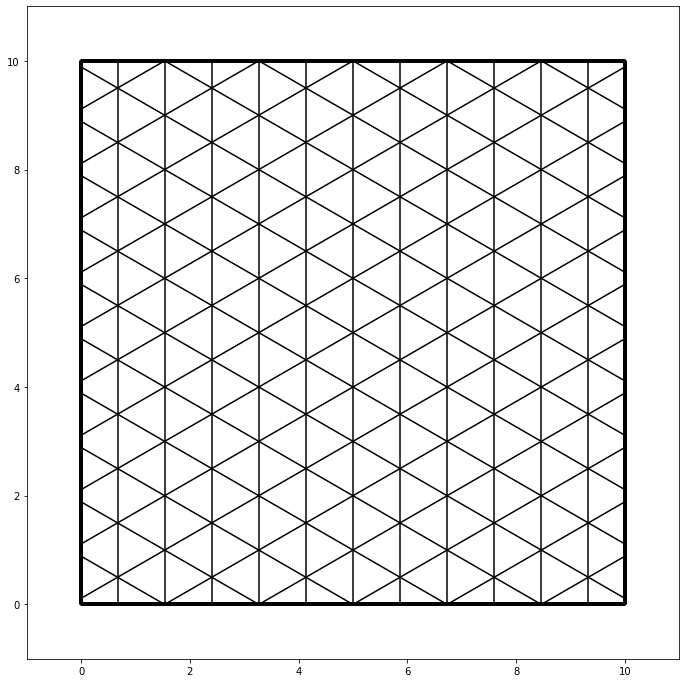

In [2]:
reload(tessellate)
tritille = tessellate.TriTille(1.,  origin=np.array([5., 5.]), angle=0.)

figure = plt.figure(figsize=(12,12))
axes = figure.add_subplot(111, aspect=1.)

tritille.display(10, origin=np.array([0., 0.]), hexgrid=True,
                 graphic=(figure, axes))

# Circuit
We will use the SSCx Dissemination circuits, beginning with the mean circuit:

In [3]:
path_circuit = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/"
circuit = Circuit(path_circuit + "CircuitConfig")

## Distribution in circuit space

We will flatmap all cells in the circuit, and begin by looking at the distribution
of cells in the circuit's 3D space.

In [8]:
all_xyzs = circuit.cells.get(properties=list("xyz"))
all_xyzs.agg(["min", "mean", "std", "median", "mad", "max"])

,x,y,z
min,1636.498786,-3620.430569,-5799.639750
mean,3977.616282,-513.576258,-2854.465128
std,1079.429535,1680.214350,1167.609554
median,3928.476528,-573.242794,-2744.288764
mad,894.354522,1415.559634,998.183553
max,6934.594844,3119.181656,-378.683296


In [18]:
long_pos = (pd.concat([all_xyzs.x, all_xyzs.y, all_xyzs.z], axis=0,
                      keys=["x", "y", "z"], names=["axis"])
            .rename("value").reset_index())

long_pos.head()

,axis,gid,value
0,x,1,4877.122429
1,x,2,5383.917646
2,x,3,5038.520009
3,x,4,4873.650857
4,x,5,4470.542212


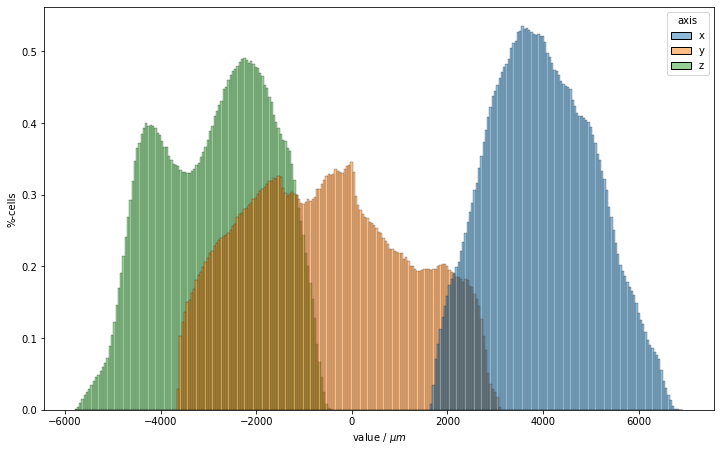

In [54]:
figure = plt.figure(figsize=(12, 12 / GOLDEN))
axes = figure.add_subplot(111, aspect="auto")
axes = sbn.histplot(long_pos, x="value", hue="axis", stat="percent")
_=axes.set_xlabel("value / $\mu m$")
_=axes.set_ylabel("%-cells")

## Distribution in the flatspace.

Each cell's position is mapped to a 2D flatspace.

**TODO**: briefly describe what flatspace, meanwhile the reader may read the release report.

The flatmap we have has a finite resolution estimated to be about  $34um$ (ask MR).
We can enhance this pixel level resolution to sub-pixel values using the
MR's `flatmap_utility`. 
We have intergrated `flatmap_utility` into the repository associated with these
*topological analyses of subvolumes*:
https://bbpgitlab.epfl.ch/conn/structural/topological-analysis-of-subvolumes


However, only 94% of the cells are covered by the flatmap.
Remaining 6% of the cells could not be *flatmapped* to a valid pixel.

**TODO** Where are these 6% cells that could not be *flatmapped*.

In [35]:
reload(hexgrid)
fmap_spxl = hexgrid.get_flatmap(circuit)
frac_cells_covered = fmap_spxl.shape[0] / circuit.cells.count()
LOG.warning("Fraction of cells covered by the  flatmap: %s", frac_cells_covered)
fmap_spxl.agg(["count", "min", "mean", "std", "median", "mad", "max"])

Fraction of cells covered by the  flatmap: 0.9397068994545127


,x,y
count,3.979592e+06,3.979592e+06
min,-4.485253e+01,-3.258549e+01
mean,2.163639e+03,2.959550e+03
std,1.441468e+03,1.781704e+03
median,1.926028e+03,2.698222e+03
mad,1.141401e+03,1.515252e+03
max,6.300128e+03,6.529197e+03


In [73]:
long_fmap = pd.concat([fmap_spxl.x, fmap_spxl.y], axis=0,
                      keys=["x", "y"], names=["axis"]).rename("value")

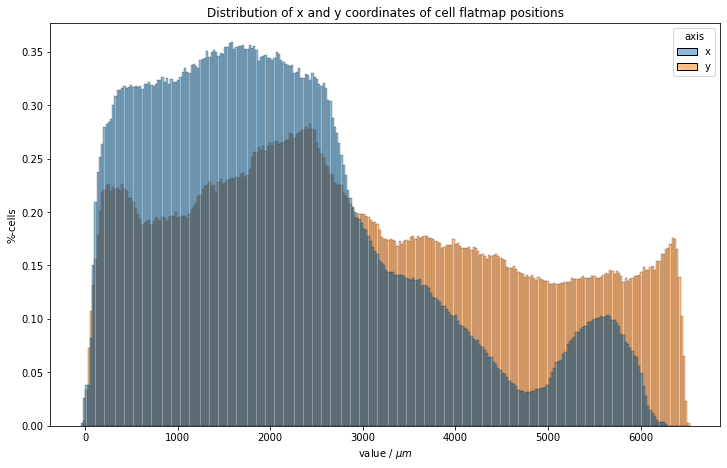

In [76]:
figure = plt.figure(figsize=(12, 12 / GOLDEN))
axes = figure.add_subplot(111, aspect="auto")

axes = sbn.histplot(long_fmap.reset_index(), x="value", hue="axis",
                    stat="percent")
_=axes.set_xlabel("value / $\mu m$")
_=axes.set_ylabel("%-cells")
_=axes.set_title("Distribution of x and y coordinates of cell flatmap positions")

# Subtarget Distribution 

We use our `flatmap_utility`'s tiling tool to generate subtargets and analyze them.
Let us first generate a subtarget of radius $230\mu m$ that has been used to generate
columnar microcircuits in the past.

In [79]:
subtargets_r230 = hexgrid.generate_subtargets(circuit, fmap_spxl, radius=230)
print(subtargets_r230.shape)
print(subtargets_r230[["i", "j", "x", "y"]].agg(["count", "mean", "std",
                                                 "median", "mad"]))
print(subtargets_r230[["i", "j", "x", "y"]].agg(["min", "max"]))

(3979592, 5)
                   i             j             x             y
count   3.979592e+06  3.979592e+06  3.979592e+06  3.979592e+06
mean   -7.435328e+00  1.829765e+01  2.163621e+03  2.959293e+03
std     9.142086e+00  7.950076e+00  1.445533e+03  1.784894e+03
median -6.000000e+00  1.800000e+01  1.991858e+03  2.760000e+03
mad     7.920058e+00  6.682280e+00  1.144228e+03  1.518652e+03
      i   j            x       y
min -28   2  -199.185843     0.0
max  12  38  6373.946972  6555.0


In [88]:
subtarget_r230__positions = (pd.concat([subtargets_r230.x, subtargets_r230.y],
                                       axis=0, keys=["x", "y"], names=["axis"])
                             .rename("value"))
subtarget_r230__positions.head(mpo)

axis  subtarget
x     R19;C0       199.185843
      R19;C0       199.185843
      R19;C0       199.185843
      R19;C0       199.185843
      R19;C0       199.185843
Name: value, dtype: float64

Subtargets are created by binning individual cell flatmap positions to centers
of hexagonal grids.
Thus the distribution of `(x, y)` values in subtarget bins for cells should
follow the same distribution as the unbinned positions.
Let us test this.

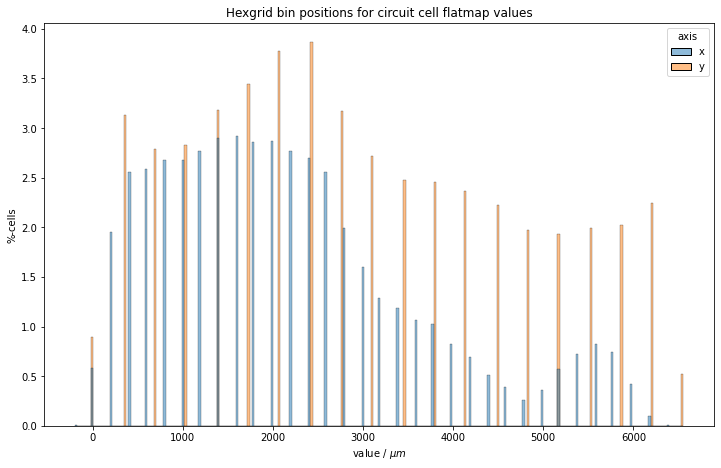

In [89]:
figure = plt.figure(figsize=(12, 12 / GOLDEN))
axes = figure.add_subplot(111, aspect="auto")

axes = sbn.histplot(subtarget_r230__positions.reset_index(), x="value", hue="axis",
                    stat="percent")
_=axes.set_xlabel("value / $\mu m$")
_=axes.set_ylabel("%-cells")
_=axes.set_title("Hexgrid bin positions for circuit cell flatmap values")

We can visualize the subtargets.

In [96]:
reload(tessellate); reload(hexgrid)
tritille_r230 = tessellate.TriTille(230.)
hexmap_r230 = tritille_r230.bin_hexagonally(fmap_spxl,
                                            use_columns_row_indexing=False)
print(hexmap_r230.shape)
hexmap_r230.head()

(3979592, 2)


,i,j
gid,,
30973,-6,6
80068,-6,6
373496,-6,6
3618315,-7,8
3658565,-7,8


There are too many cells.
To show the shape of the hexgrid in the flatspace we can plot a small fraction
of all positions.

available values  x    1.0
y    1.0
dtype: float64
                 x            y
gid                            
30973    29.910201  1580.957942
80068    20.648030  1591.144575
373496   26.567832  1558.500571
3618315  18.095272  1603.279187
3658565  25.725519  1616.660220


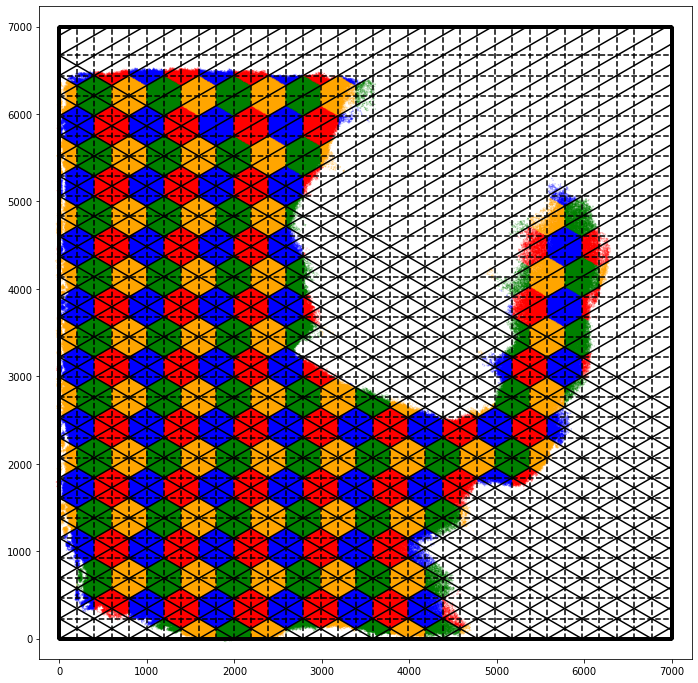

In [106]:
figure = plt.figure(figsize=(12, 12))
axes = figure.add_subplot(111, aspect=1.)
fpos = hexgrid.get_flatmap(circuit, sample=None)
print("available values ", 1. - fpos.isna().sum() / fpos.shape[0])
fpos.dropna()
print(fpos.head())
graphic = tritille_r230.display(7000, graphic=(figure, axes))
graphic = tritille_r230.plot_hextiles(fpos.dropna(), graphic=graphic,
                                      annotate=False, with_grid=False,
                                      pointmarker=".", pointmarkersize=0.05)
#grid = tritille.locate_grid(tiles)
#print(grid.shape)
#grid = grid[np.logical_and(grid.x > -1.e6, grid.y > -1.e6)]
#plt.scatter(grid["x"], grid["y"], c="red", s=80)

In [108]:
figure.savefig("./hexgrids_r230.png")

In [109]:
pwd

'/gpfs/bbp.cscs.ch/project/proj83/home/sood/analyses/manuscript/define_subtargets/notebooks'

In [195]:
print(tiles.shape)
tiles.head()

(38, 2)


,i,j
gid,,
474998,-2,3
576456,-1,6
1615391,2,9
68352,0,2
1999115,2,5


In [267]:
fpos = hexgrid.get_flatmap(circuit, sample=2.e-5)
print(fpos.shape)
print(1 - fpos.isna().sum() / fpos.shape[0])
fpos = fpos.dropna()
#tiles = tritille.bin_rhombically(fpos)
tiles = tritille.bin_trinagularly(fpos)
grid = tritille.locate_grid(tiles)
bins = tiles.value_counts().sort_index()

(85, 2)
x    0.988235
y    0.988235
dtype: float64


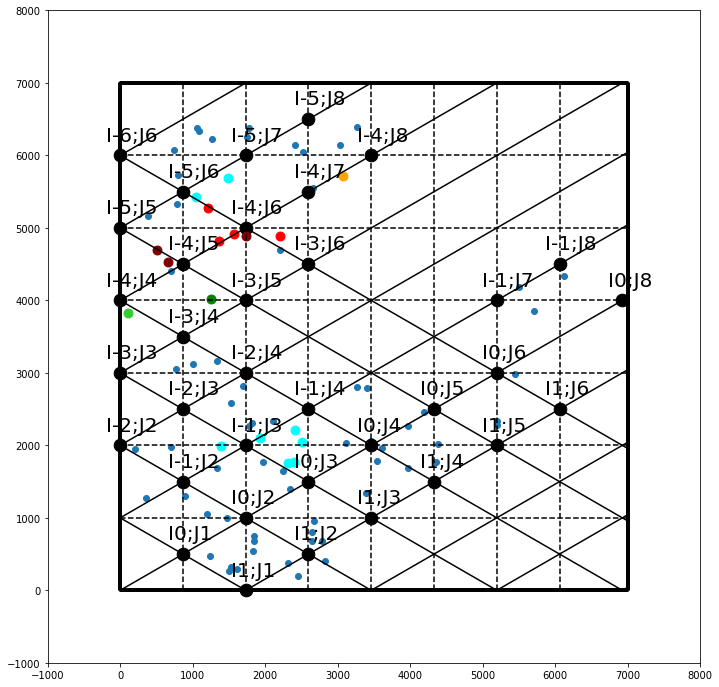

In [268]:
figure = plt.figure(figsize=(12, 12))
axes = figure.add_subplot(111, aspect=1.)

graphic = tritille.display(7000, graphic=(figure, axes))

plt.scatter(fpos.x, fpos.y)

plt.scatter(grid.x, grid.y, c="black", s=160)

annotate = tritille.annotate(grid)
for row in grid.assign(annotation=annotate).itertuples():
    axes.annotate(row.annotation, (row.x - 200, row.y + 200), fontsize=20)

def plot_bin(i, j, c, s):
    try:
        qgids = tiles[np.logical_and(tiles.i == i, tiles.j == j)].index.values
    except KeyError:
        pass
    else:
        qpos = circuit.flatmap_positions.loc[qgids]
        plt.scatter(qpos.x, qpos.y, c=c, s=s)

plot_bin(-4, 5, "maroon", 80)
plot_bin(-4, 6, "red", 80)
plot_bin(-4, 7, "orange", 80)

plot_bin(-3, 5, "green", 80)
plot_bin(-3, 4, "limegreen", 80)

plot_bin(-5, 6, "cyan", 80)
plot_bin(-1, 3, "cyan", 80)
#tiles = tritille.bin_hexagonally(fpos, use_columns_row_indexing=False)
#print(tiles.shape)
#print(1 - tiles.isna().sum() / tiles.shape[0])
#tiles.head()

In [258]:
htiles = tritille.bin_hexagonally(fpos)
htiles.loc[tiles[np.logical_and(tiles.i == -1, tiles.j == 3)].index]

,i,j
gid,,
1322672,0,3
2804353,0,3
2683403,0,3


In [ ]:
reload(hexgrid)
sample_frac = 1.e-3
radius, subtargets = hexgrid.generate_subtargets(circuit, size=30000,
                                                 sample=sample_frac)

In [6]:
print(radius, subtargets.shape[0])
subtargets.head()

5.535858154296875 3986


,i,j,gid,x,y
subtarget,,,,,
R11;C4,-12,21,515,43.147744,91.34166
R11;C4,-12,21,3586913,43.147744,91.34166
R11;C4,-12,21,186505,43.147744,91.34166
R11;C4,-12,21,2519138,43.147744,91.34166
R11;C4,-12,21,4103866,43.147744,91.34166


In [7]:
subtarget_sizes = subtargets.groupby("subtarget").size() / sample_frac
print(subtarget_sizes.agg(["min", "mean", "std", "median", "mad", "max"]))

min        1000.000000
mean      30196.969697
std       15653.909296
median    33000.000000
mad       13200.413223
max       59000.000000
dtype: float64


In [8]:
subtargets.gid.min()

289

## Using a config

We can use a configuration to define subtargets.

In [124]:
import read_config
reload(hexgrid)
path_config = "topological-analysis-of-subvolumes/reduced_example_config.json"
config = hexgrid.SubtargetConfig(path_config, reader=read_config)
print(config.input_circuit.keys())
config.output, config.target_radius, config.mean_target_size

dict_keys(['Bio_M'])


(('/gpfs/bbp.cscs.ch/project/proj83/home/sood/analyses/manuscript/define_subtargets/notebooks/results/topological_sampling.h5',
  'subtargets'),
 230.0,
 None)

In [191]:
reload(hexgrid)
sample_frac = None

subtargets_wide = hexgrid.define_subtargets(config,
                                            sample_frac=sample_frac,
                                            format="wide")

GENERATE subtargets for circuit Bio_M
DONE 3979592 subtargets for circuit Bio_M


In [195]:
fpos = (subtargets_wide.apply(len).rename("number").reset_index()
        .rename(columns={"flat_x": "x", "flat_y": "y"})
        .set_index(["circuit", "subtarget"]))
fpos_valid = fpos[np.logical_and(fpos.x > 0, fpos.y > 0)]
fpos_valid.head()

x       y  number
circuit subtarget                              
Bio_M   R10;C0     2.112516e-13  3450.0    7641
        R10;C1     3.983717e+02  3450.0   25260
        R10;C12    4.780460e+03  3450.0      12
        R10;C13    5.178832e+03  3450.0    5374
        R10;C14    5.577204e+03  3450.0   19645

In [200]:
fpos.number / fpos.number.mean()

circuit  subtarget
Bio_M    R0;C10       0.417026
         R0;C11       0.204261
         R0;C12       0.011544
         R0;C2        0.000248
         R0;C3        0.158642
                        ...   
         R9;C4        1.459498
         R9;C5        1.480290
         R9;C6        1.347281
         R9;C7        0.500195
         R9;C8        0.001179
Name: number, Length: 247, dtype: float64

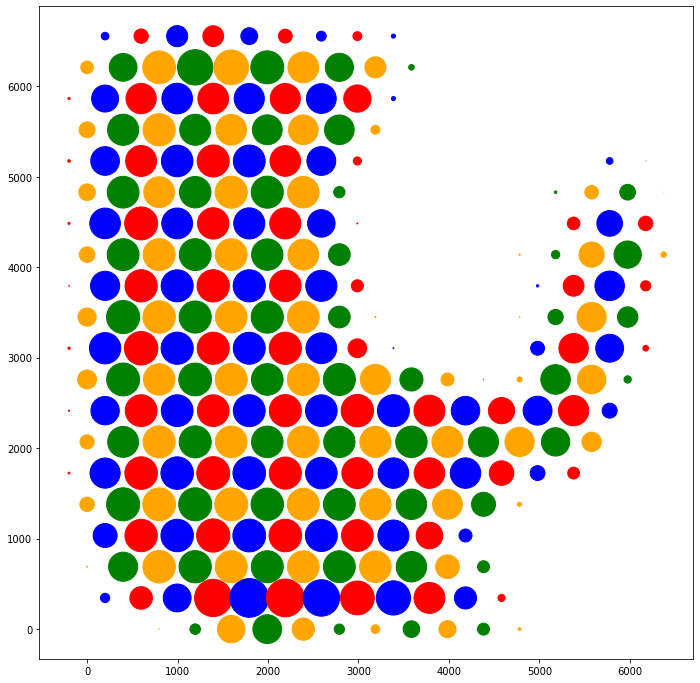

In [211]:
reload(hexgrid)
figure = plt.figure(figsize=(12, 12))
axes = figure.add_subplot(111, aspect=1.)
    
graphic = (figure, axes)
#graphic = tritille_r230.display(7000, graphic=(figure, axes))
graphic = tritille_r230.plot_hextiles(fpos[["x", "y"]], graphic=graphic,
                                      annotate=False, with_grid=False,
                                      pointmarker="o",
                                      pointmarkersize=700*fpos.number / fpos.number.mean()),
#grid = tritille.locate_grid(tiles)
#print(grid.shape)
#grid = grid[np.logical_and(grid.x > -1.e6, grid.y > -1.e6)]
#plt.scatter(grid["x"], grid["y"], c="red", s=80)


In [214]:
pwd

'/gpfs/bbp.cscs.ch/project/proj83/home/sood/analyses/manuscript/define_subtargets/notebooks'

In [215]:
figure.savefig("hexgrid_r230_sizes.png", dpi=200)

In [19]:
hexmap = tritille.bin_hexagonally(flatmap, use_columns_row_indexing=False)
print(hexmap.shape)
hexmap.head()

(3979592, 2)


,i,j
gid,,
1,-9,78
2,-1,86
3,2,35
4,-2,37
5,-20,103


In [20]:
grid = tritille.locate_grid(hexmap)
print(grid.shape)
grid.head()

(3298, 2)


,,x,y
i,j,,
-9,78,69.755753,53.5
-1,86,83.612159,53.5
2,35,42.042940,26.5
-2,37,40.310889,29.5
-20,103,81.880109,71.5


In [21]:
annotation = tritille.annotate(grid, using_column_row=True)
print(annotation.shape)
annotation.head()

(3298,)


i    j  
-9   78     R29;C34
-1   86     R29;C42
 2   35     R11;C18
-2   37     R13;C17
-20  103    R41;C41
dtype: object

In [22]:
gids_by_gridpoint = hexmap.reset_index().set_index(["i", "j"])
print(gids_by_gridpoint.shape)
gids_by_gridpoint.head()

(3979592, 1)


,,gid
i,j,
-9,78,1
-1,86,2
2,35,3
-2,37,4
-20,103,5


In [23]:
annotated_grid = grid.assign(subtarget=annotation.loc[grid.index])
print(annotated_grid.shape)
annotated_grid.head()

(3298, 3)


,,x,y,subtarget
i,j,,,
-9,78,69.755753,53.5,R29;C34
-1,86,83.612159,53.5,R29;C42
2,35,42.042940,26.5,R11;C18
-2,37,40.310889,29.5,R13;C17
-20,103,81.880109,71.5,R41;C41


In [24]:
q = gids_by_gridpoint.join(annotated_grid).reset_index().set_index("subtarget")
print(q.shape)
q.head()

(3979592, 5)


,i,j,gid,x,y
subtarget,,,,,
R55;C17,-65,100,9210,40.310889,92.5
R55;C17,-65,100,79774,40.310889,92.5
R55;C17,-65,100,98105,40.310889,92.5
R55;C17,-65,100,124131,40.310889,92.5
R55;C17,-65,100,183562,40.310889,92.5


In [25]:
q.gid.agg(["mean", "min", "median", "max", "std", "mad"])

mean      2.119484e+06
min       1.000000e+00
median    2.132972e+06
max       4.234929e+06
std       1.225370e+06
mad       1.062646e+06
Name: gid, dtype: float64

# Supersampling

In [8]:
import flatmap_utility as fmut
from voxcell.voxel_data import OrientationField, VoxelData

In [9]:
reload(fmut)
flatmap = circuit.atlas.load_data("flatmap")
orientations = circuit.atlas.load_data("orientation", cls=OrientationField)
#q = fmut.supersampled_neuron_locations(circuit, flatmap, orientations)
                                              


In [10]:
reload(fmut)
flatmap = circuit.atlas.load_data("flatmap")
orientations_vd = circuit.atlas.load_data("orientation", cls=VoxelData)
#q = fmut.supersampled_neuron_locations(circuit, flatmap, orientations_vd)
                                              

In [72]:
zeros


(array([  0,   0,   0, ..., 408, 408, 408]),
 array([  0,   0,   0, ..., 607, 607, 607]),
 array([  0,   1,   2, ..., 283, 284, 285]))

In [11]:
oarray = orientations.raw
norms = np.linalg.norm(oarray, axis=3)
zeros = np.where(np.isclose(norms, 0.))
oarray[zeros[0:5]]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int8)

In [76]:
#zeros_index = list(zip(*zeros))
#zeros_index
zeros_poses = orientations.indices_to_positions(zeros_index[0:10])

In [78]:
zeros_poses[0]

array([-8124.92919922, -7919.99853516,  -144.3999939 ])

In [79]:
orientations.lookup(zeros_poses[0])

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]])

In [31]:
vxl_frame = fmut.voxel_flat_coordinate_frame(flatmap)
print(vxl_frame.shape)
vxl_frame.head()

(1257014, 3)


x            y            z
f_x f_y                                       
2   111  1636.240005  1686.231476 -1848.731125
    111  1636.240005  1686.231476 -1887.465923
    110  1636.240005  1686.231476 -1926.200722
    112  1636.240005  1724.966274 -1771.261528
    111  1636.240005  1724.966274 -1809.996326

In [33]:
per_pixel = vxl_frame.groupby(["f_x", "f_y"])

per_pixel_negative_center = per_pixel.apply(lambda x: -np.mean(x.values, axis=0))

print(per_pixel_negative_center.shape)
per_pixel_negative_center.head()

(12702,)


f_x  f_y
0    27     [-3370.367135267991, 2684.8415471590483, 1941....
     28     [-3381.7783688484355, 2658.6591056661405, 1907...
     29     [-3426.1954277440122, 2622.505181262368, 1832....
     30     [-3333.242931365967, 2546.3304176330566, 1922....
     31     [-3354.343509250217, 2504.012941148546, 1859.9...
dtype: object

In [39]:
per_pixel_orient = (per_pixel_negative_center
                    .apply(lambda x: orientations.lookup(-x)))
print(per_pixel_orient.shape)
per_pixel_orient.head()

(12702,)


f_x  f_y
0    27     [[[0.4922209136552408, 0.6426579061550858, -0....
     28     [[[0.4922209136552408, 0.6426579061550858, -0....
     29     [[[0.5040609771335749, 0.6376358865425465, -0....
     30     [[[0.5412120091239752, 0.6167313975710498, -0....
     31     [[[0.5412120091239752, 0.6167313975710498, -0....
dtype: object

In [40]:
per_pixel_orient_vd = (per_pixel_negative_center
                       .apply(lambda x: orientations_vd.lookup(-x)))
print(per_pixel_orient.shape)
per_pixel_orient.head()


NameError: name 'orientations_vd' is not defined